In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from auxFunctions import *

In [2]:
plt.rcParams['figure.figsize']=[8,8]
%config InlineBackend.figure_format = 'retina'

In [3]:
os.chdir("../..")
os.getcwd()
 

'/Volumes/shared/Molekylär Neurobiologi/Castelo-Branco/Mukund/CZI_ADULT/CZI_ATAC'

In [4]:
ab_dict = {"H3K27ac":"P20057_1004", 
           "H3K27me3":"P20057_1005",
           "H3K4me3":"P20057_1006"
          }

#ab_dict = {"H3K27ac" : ""}

#### Set the antibody before running the notebook!

In [5]:
antibody = "H3K27ac"

## Barcode Filtering

### Read in the barcode statistics files

In [6]:
all_barcode_files = stripReformat("data/barcode_statistics/{}_all_barcodes.txt".format(ab_dict[antibody]))
peak_barcodes_file = stripReformat("data/barcode_statistics/{}_stringent.peak_barcodes.txt".format(ab_dict[antibody]))
metadata_file = "data/{}/singlecell.csv".format(ab_dict[antibody])

In [7]:
all_barcodes = pd.read_csv(all_barcode_files, sep="\t", header=None, index_col=False, names=["all_unique_CT", "barcode"])
#rlxd_peak_bcd = pd.read_csv(rlxd_peak_barcodes_file, sep="\t", header=None, index_col=False, names=["peak_CT","barcode"])
peak_bcd = pd.read_csv(peak_barcodes_file, sep="\t", header=None, index_col=False, names=["peak_CT","barcode"])
metadata = pd.read_csv(metadata_file, sep=",", header=0)

In [8]:
if "NO_BARCODE" in metadata.barcode.values:
    metadata = metadata[metadata.barcode != "NO_BARCODE"]
    
metadata["logUMI"] = np.log10(metadata.passed_filters + 1)
metadata["promoter_ratio_10x"] = (metadata.promoter_region_fragments + 1)/(metadata.passed_filters + 1)
metadata["peak_region_ratio_10x"] = (metadata.peak_region_fragments + 1)/(metadata.passed_filters + 1)

In [9]:

strng_bcd = pd.merge(peak_bcd, all_barcodes)[["barcode", "all_unique_CT", "peak_CT"]]
strng_bcd["peak_ratio_CT"] = strng_bcd.peak_CT / strng_bcd.all_unique_CT
metadata_str = pd.merge(metadata, strng_bcd)
metadata_str["passed_CT"] = "False"

### Set thresholds for filtering

In [10]:
cutoff_reads_min = 10**3
cutoff_read_max = 10**5.5

if antibody == "H3K27ac":
    cutoff_peak_percentage_low = 0.6
    cutoff_peak_percentage_high = 0.95
elif antibody == "H3K4me3":
    cutoff_peak_percentage_low = 0.5
    cutoff_peak_percentage_high = 0.98
elif antibody == "H3K27me3":
    cutoff_peak_percentage_low = 0.4
    cutoff_peak_percentage_high = 0.8

In [11]:
metadata_str.loc[(metadata_str.all_unique_CT > cutoff_reads_min) & 
    (metadata_str.all_unique_CT < cutoff_read_max) &
    (metadata_str.peak_ratio_CT > cutoff_peak_percentage_low) &
    (metadata_str.peak_ratio_CT < cutoff_peak_percentage_high), "passed_CT"] = True

### Plot scatterplot of filtered cells

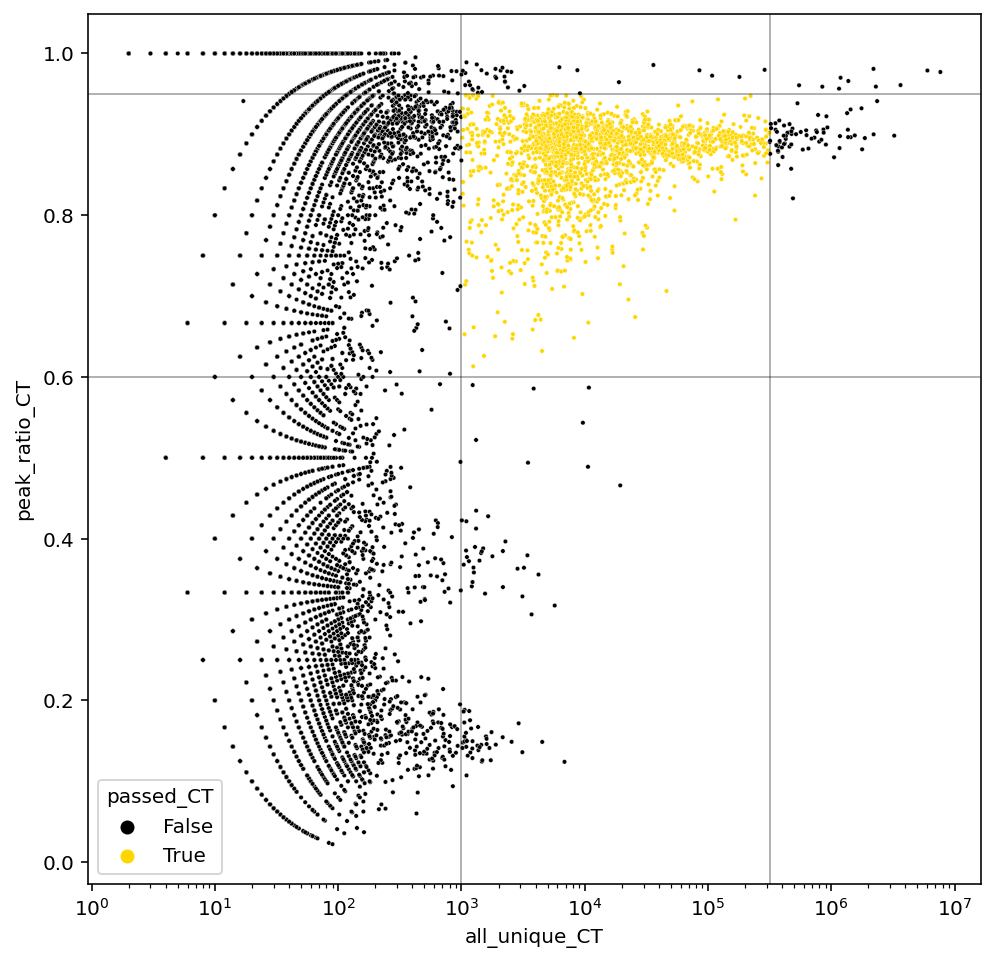

In [12]:
cell_plot = sns.scatterplot(data=metadata_str, x="all_unique_CT", y="peak_ratio_CT", 
                            hue="passed_CT", palette=["black", "gold"], s=5)
cell_plot.set(xscale="log")
plt.axhline(y = cutoff_peak_percentage_low, color='black', linewidth=1, alpha=.3)
plt.axhline(y = cutoff_peak_percentage_high, color='black', linewidth=1, alpha=.3)
plt.axvline(x = cutoff_reads_min, color='black', linewidth=1, alpha=.3)
plt.axvline(x = cutoff_read_max, color='black', linewidth=1, alpha=.3)

In [13]:
len(metadata_str[metadata_str.passed_CT==True])

1872

### Filter the metadata and the fragments file

In [14]:
passed_CT = metadata_str[metadata_str.passed_CT==True]
filtered_barcode_list = passed_CT.barcode.values.tolist()

In [68]:
passed_CT.to_csv("data/{}/MK_pre_singlecell.csv".format(ab_dict[antibody]), index=False)

In [16]:
passed_CT

,barcode,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,cell_id,is__cell_barcode,...,blacklist_region_fragments,peak_region_fragments,peak_region_cutsites,logUMI,promoter_ratio_10x,peak_region_ratio_10x,all_unique_CT,peak_CT,peak_ratio_CT,passed_CT
70,AAACGAAAGTCCTTCC-1,4812,3822,6,79,232,5,668,_cell_0,1,...,0,600,1171,2.825426,0.748879,0.898356,9450,8326,0.881058,True
150,AAACGAACAGGTCCTG-1,70060,60316,116,1086,2612,41,5889,_cell_1,1,...,0,5331,10431,3.770115,0.767402,0.905263,137682,123008,0.893421,True
158,AAACGAACAGTATCTG-1,73235,62238,490,920,3484,39,6064,_cell_2,1,...,0,5442,10694,3.782831,0.774444,0.897444,144366,128906,0.892911,True
203,AAACGAAGTAGAGAGA-1,34388,28798,81,705,1612,4,3188,_cell_3,1,...,0,2842,5564,3.503655,0.755409,0.891502,67174,59192,0.881174,True
271,AAACGAATCAAACCCA-1,1019,916,1,30,35,0,37,None,0,...,0,34,65,1.579784,0.842105,0.921053,1974,1814,0.918946,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107346,TTTGTGTCAATACTGC-1,10027,8143,17,139,422,62,1244,_cell_1674,1,...,0,1114,2171,3.095169,0.751004,0.895582,19732,17402,0.881918,True
107375,TTTGTGTCAGCGTAGA-1,1676,1337,1,26,78,0,234,_cell_1675,1,...,0,215,428,2.371068,0.795745,0.919149,3288,3022,0.919100,True
107410,TTTGTGTGTACGGAGT-1,12853,10865,38,260,481,0,1209,_cell_1676,1,...,0,1037,2023,3.082785,0.753719,0.857851,25098,21134,0.842059,True
107463,TTTGTGTGTTACGCTA-1,8435,6789,7,173,407,5,1054,None,0,...,0,972,1911,3.023252,0.794313,0.922275,16472,14846,0.901287,True


In [17]:
passed_CT["barcode"].to_csv("/Users/mukkab/Downloads/ArchR/scCT/scripts/H3K27ac_N2_passed_barcodes.csv", index=False, header=False)
#passed_CT["barcode"].to_csv("data/{}/barcodes.txt".format(ab_dict[antibody]), index=False, header=False)

In [92]:
FRAGMENTS_PATH = "../../../NGSDATA/scATAC_human_adult_CZI_2/Processed_data/cellranger_output/{}/fragments.tsv.gz".format(ab_dict[antibody])

In [93]:
#%%time
#filterFragments(barcodelist=filtered_barcode_list,
#                fragments=FRAGMENTS_PATH, 
#                out_gz="data/CT_processed_fragments/{}_FILTERED.fragments.tsv".format(ab_dict[antibody]))

Run preArchR.sh from scripts/ before running generating ArrowFiles in ArchR


## Now run ArchR using the filtered Fragments